# RNN Testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import re

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import rnn

In [3]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Choose organism

In [4]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]
print(f"Using organism: {organism}")

Using organism: E.Coli


### Test Dataset Preparation

In [5]:
batch_size = 1
min_length = None
max_length = None
padding_pos = "right" if batch_size > 1 else None
shuffled = False

test_dataset = mlh.CodonDataset(organism=organism, split="test", shuffled=shuffled, min_length=min_length, max_length=max_length, padding_pos=padding_pos)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print("Länge test_dataset:", len(test_dataset))

Länge test_dataset: 386


### Load all trained RNN models for specific organism and compare them

In [6]:
all_trained_models = mlh.load_model("rnn", organism, device=device, get_all=True)

rnnModel = None # save the best model for further evaluation
accuracy = 0
predicted = None
labels = None

for trained_model in all_trained_models:
    name, model = trained_model.values()
    epochs = re.search(r'epochs(\d+)', name).group(1)
    pre, lab, acc = rnn.evaluate(model, test_loader, device=device)
    if acc > accuracy:
        rnnModel, predicted, labels, accuracy = model, pre, lab, acc
    print(f"{name:<65} Epochs: {epochs:>2}  Accuracy: {acc*100:.2f}%")

print("="*100)
print(f"best model with Accuracy {accuracy*100:.2f}%")
print(f"{model}")

Loaded 1 models
20240625161053_rnn_hidden128_epochs15_lr0.001_optimSGD.pt         Epochs: 15  Accuracy: 52.46%
best model with Accuracy 52.46%
RNN(
  (i2h): Linear(in_features=22, out_features=128, bias=False)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=65, bias=True)
)


In [7]:
predicted_codon_names =  mle.codon_to_name(predicted)
labels_codon_names =  mle.codon_to_name(labels)

predicted_aa =  mle.translate_codons(predicted_codon_names)
labels_aa =  mle.translate_codons(labels_codon_names)

mle.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
mle.print_unique_elements(predicted_aa, labels_aa)

accuracy_aa = accuracy_score(labels_aa, predicted_aa)
print(f'Accuracy of amino acids: {accuracy_aa*100:.2f}%')

predicted different classes:  50 out of: 61
predicted following classes:  {'CCA', 'GAC', 'TTT', 'ATG', 'CCT', 'TAC', 'ACA', 'GGG', 'CAG', 'CCG', 'GAA', 'GTG', 'GAT', 'CGT', 'TGC', 'TGG', 'GGA', 'GCA', 'ATC', 'TCG', 'TCC', 'CAT', 'GCC', 'GCT', 'TTC', 'CGC', 'GCG', 'CAC', 'AGC', 'TTA', 'GTA', 'TCA', 'TGT', 'AAC', 'TCT', 'GTT', 'AAT', 'GAG', 'GTC', 'ACC', 'CTC', 'CAA', 'GGC', 'ACG', 'CTG', 'AAA', 'TAT', 'CCC', 'GGT', 'ATT'}
predicted different amino acids:  20 out of: 20
Accuracy of amino acids: 100.00%


## Result Visualization

### Index-based Segment Accuracy

In [8]:
classifier = rnn.RNN_Classifier(rnnModel)
predicted_seg, labels_seg = classifier.predict_codons(test_loader, device)

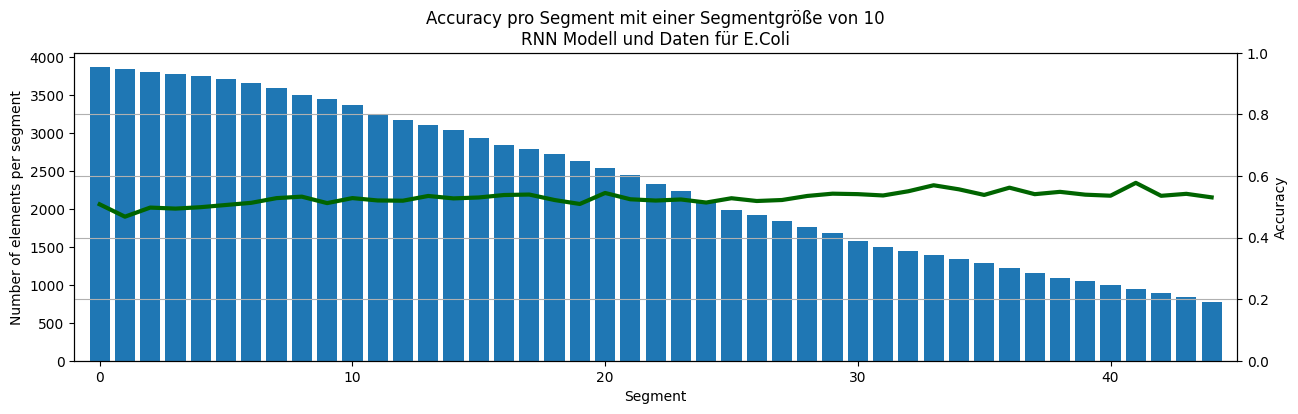

In [9]:
segment_size = 10
cut_data_at = 0.25

seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels_seg, predicted_seg, segment_size=segment_size, cut_data_at=0.2)
mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nRNN Modell und Daten für {organism}")
    

### Confusion Matrix (Codons)

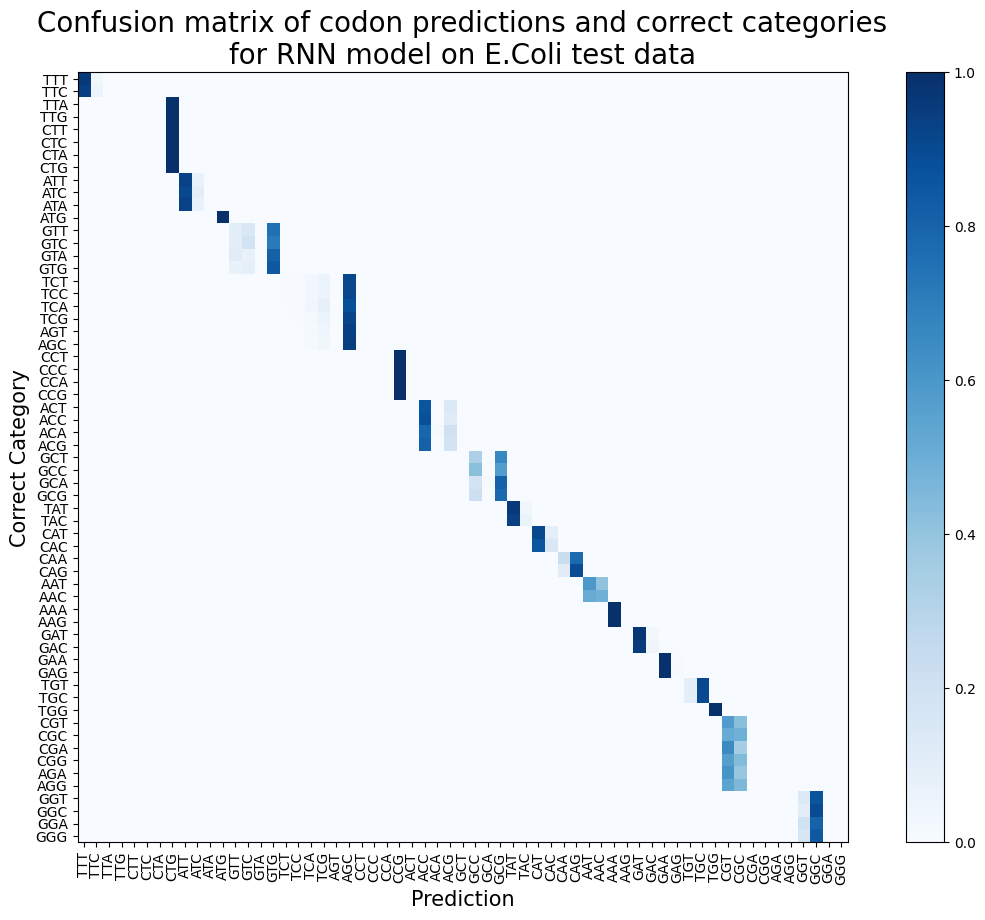

In [10]:
title = f'Confusion matrix of codon predictions and correct categories\nfor RNN model on {organism} test data'

codons = [c for c in mlh.codons if c != '___']

plt = mle.plot_confusion_matrix(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()

### Confusion Matrix (Amino acids)

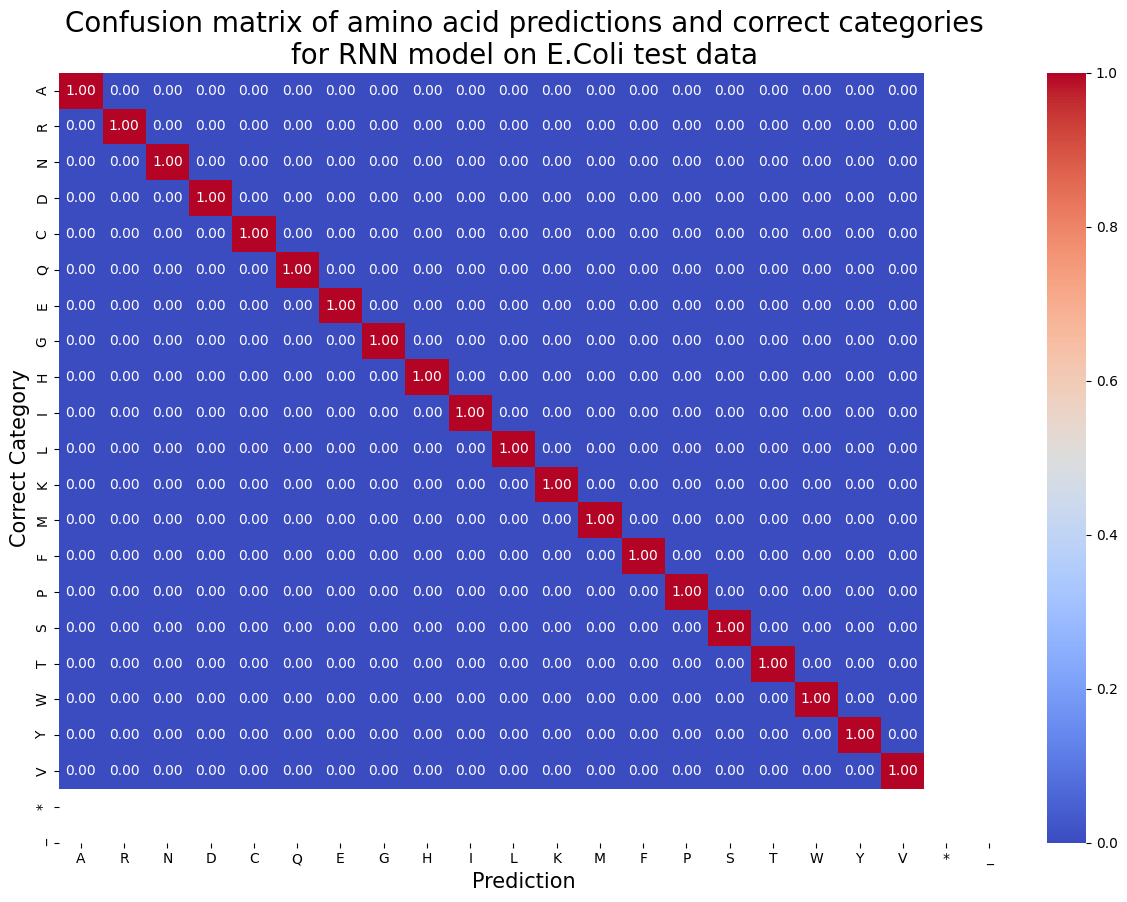

In [11]:
plt = mle.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        f'Confusion matrix of amino acid predictions and correct categories\nfor RNN model on {organism} test data')
plt.show()

### Accuracy per Codon

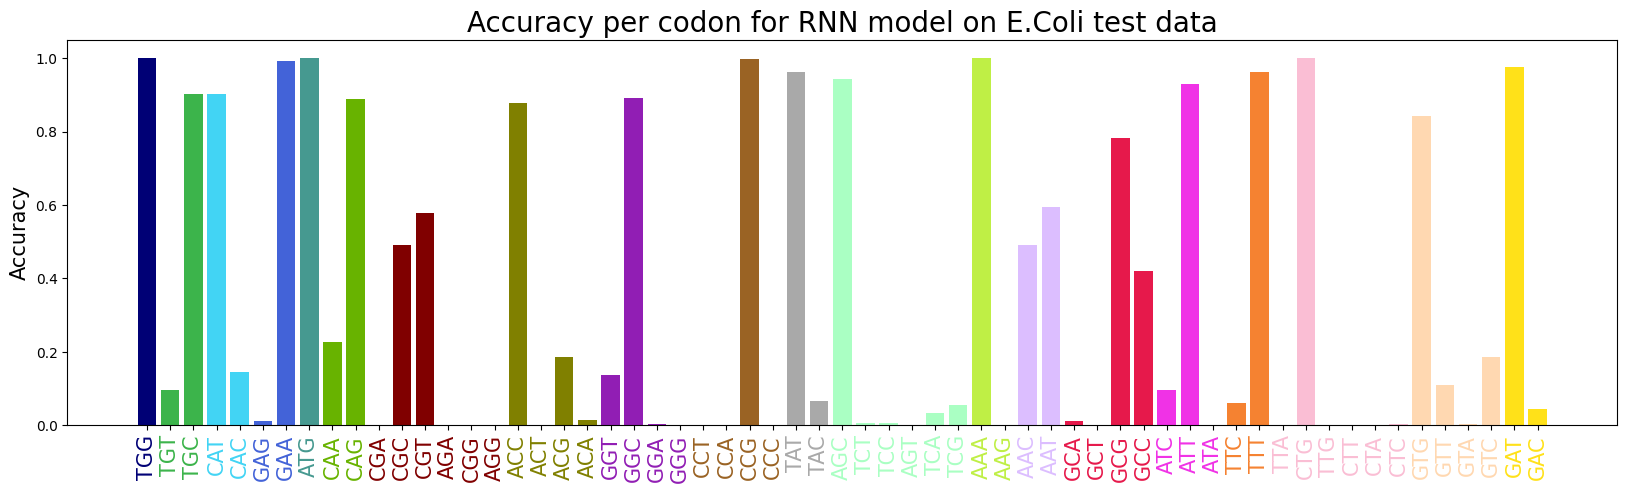

In [12]:
plt = mle.plot_codon_acc(labels, predicted, f'Accuracy per codon for RNN model on {organism} test data')

### Relative Prediction Frequency per Codon

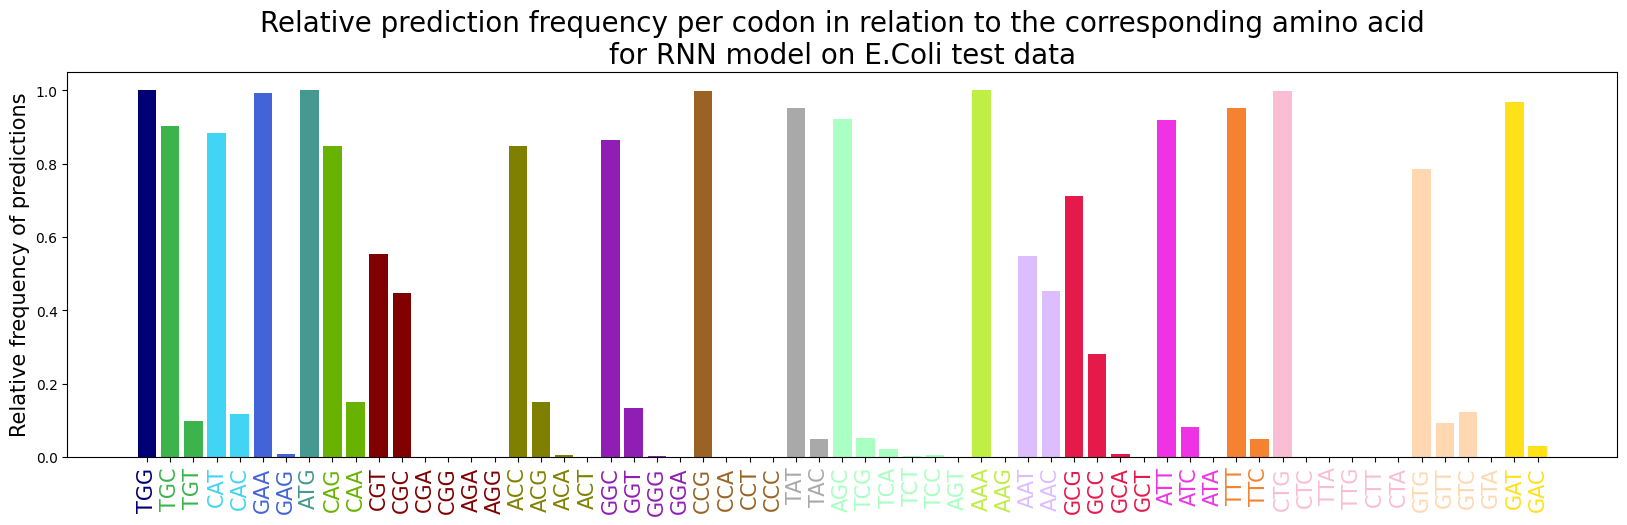

In [13]:
codon_counted_predicted = mle.codon_count(predicted)
plt = mle.plot_relative_codon_count(codon_counted_predicted,predicted, f'Relative prediction frequency per codon in relation to the corresponding amino acid\nfor RNN model on {organism} test data')

### Comparison Max CUB with Model Diagrams

In [14]:
predicted_codon_names =  mle.codon_to_name(predicted)
labels_codon_names =  mle.codon_to_name(labels)

pn_dict = mle.create_pn_dict(predicted_codon_names, labels_codon_names, organism)
cub_test_data = {}

for codon in pn_dict:
    aa = mlh.codon_to_amino_acid[codon]
    aa_codons = mlh.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum


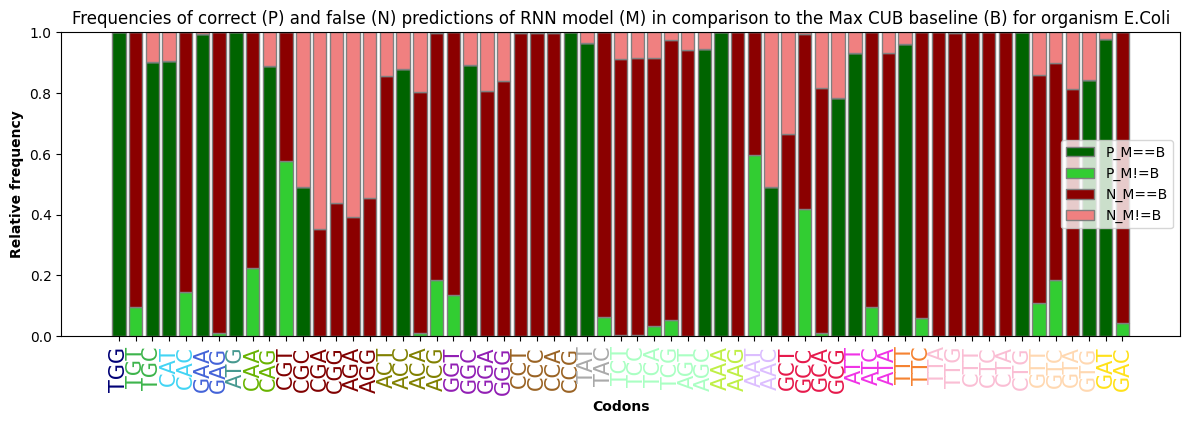

In [15]:
mle.plot_pn_dict(pn_dict, 'RNN', organism).show()